In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymks
import numpy as np
from PIL import Image
from Scripts import SpatialCorrelations as corr
import matplotlib.pyplot as plt
import pandas as pd
import os
from Scripts import velocityCalculations as vel
from Scripts import hoshenKopleman as hosh

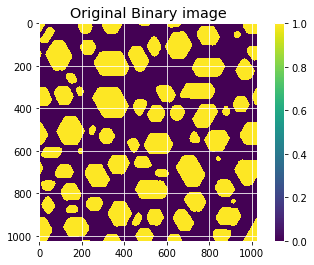

407019


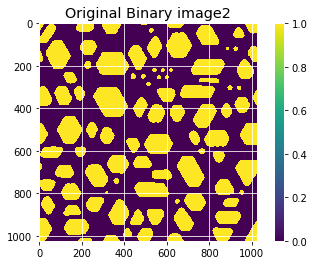

404200


In [2]:
path = '/Users/adithyaiyer/Desktop/DDP/Datasets/TimeSeries/'
list_files = os.listdir(path)
list_files.sort()
j = 0
for i in list_files:
    list_files[j] = path+i
    j = j+1
    
img_ = corr.dat_to_numpy(list_files[198])
img_ = vel.gaussian_filter(img_,4)
img_ = (img_>0.5)*1

plt.imshow(img_)
plt.colorbar()
plt.title('Original Binary image')
plt.show()
print(np.sum(img_))

img_ = corr.dat_to_numpy(list_files[144])
img_ = vel.gaussian_filter(img_,4)
img_ = (img_>0.5)*1

plt.imshow(img_)
plt.colorbar()
plt.title('Original Binary image2')
plt.show()
print(np.sum(img_))



In [3]:
labels = hosh.hoshenKoplemanLabels(img_)

In [4]:
np.max(labels)

100

In [5]:
A = []
for i in range(34):
    img_ = corr.dat_to_numpy(list_files[i*6])
    img_ = vel.gaussian_filter(img_,4)
    img_ = (img_>0.5)*1
    labels = hosh.hoshenKoplemanLabels(img_)
    print(6*i,'th image = ',np.max(labels), ' shapes')
    A.append(np.max(labels))
    

0 th image =  0  shapes
6 th image =  815  shapes
12 th image =  645  shapes
18 th image =  530  shapes
24 th image =  423  shapes
30 th image =  349  shapes
36 th image =  320  shapes
42 th image =  295  shapes
48 th image =  279  shapes
54 th image =  275  shapes
60 th image =  259  shapes
66 th image =  236  shapes
72 th image =  220  shapes
78 th image =  201  shapes
84 th image =  187  shapes
90 th image =  174  shapes
96 th image =  154  shapes
102 th image =  146  shapes
108 th image =  137  shapes
114 th image =  124  shapes
120 th image =  117  shapes
126 th image =  112  shapes
132 th image =  106  shapes
138 th image =  99  shapes
144 th image =  100  shapes
150 th image =  94  shapes
156 th image =  90  shapes
162 th image =  89  shapes
168 th image =  81  shapes
174 th image =  81  shapes
180 th image =  78  shapes
186 th image =  77  shapes
192 th image =  75  shapes
198 th image =  75  shapes


Text(0, 0.5, 'Number of ppt')

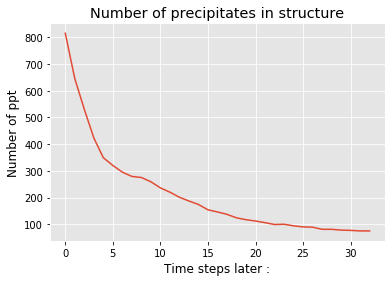

In [6]:
plt.plot(A[1:])
plt.title('Number of precipitates in structure')
plt.xlabel('Time steps later :')
plt.ylabel('Number of ppt')

In [5]:
A = []
img_ = corr.dat_to_numpy(list_files[199])
img_ = vel.gaussian_filter(img_,4)
img_ = (img_>0.5)*1
labels_199 = hosh.hoshenKoplemanLabels(img_)
uniqueLabels = np.unique(labels_199).tolist()


In [6]:
for i in uniqueLabels[1:]:
    A.append(hosh.precipitateCentres(labels_199,i))

In [7]:
(A)

[(16, 11),
 (22, 217),
 (22, 341),
 (5, 495),
 (9, 632),
 (23, 992),
 (58, 793),
 (58, 39),
 (104, 655),
 (54, 930),
 (109, 540),
 (113, 229),
 (152, 92),
 (137, 1003),
 (165, 467),
 (142, 4),
 (190, 340),
 (207, 795),
 (220, 967),
 (258, 151),
 (318, 746),
 (330, 595),
 (340, 115),
 (319, 191),
 (346, 25),
 (371, 335),
 (347, 1014),
 (381, 948),
 (392, 472),
 (435, 779),
 (424, 550),
 (420, 648),
 (412, 878),
 (506, 147),
 (521, 15),
 (519, 988),
 (503, 250),
 (530, 317),
 (550, 835),
 (538, 730),
 (566, 560),
 (572, 443),
 (606, 58),
 (599, 195),
 (662, 373),
 (695, 711),
 (653, 485),
 (637, 841),
 (697, 975),
 (681, 6),
 (716, 272),
 (697, 118),
 (704, 577),
 (775, 871),
 (781, 529),
 (761, 42),
 (794, 148),
 (837, 733),
 (855, 42),
 (849, 259),
 (836, 913),
 (894, 378),
 (874, 154),
 (908, 889),
 (911, 544),
 (926, 677),
 (922, 461),
 (957, 174),
 (969, 25),
 (985, 1001),
 (994, 495),
 (994, 858),
 (1008, 634),
 (1008, 342),
 (1021, 223)]

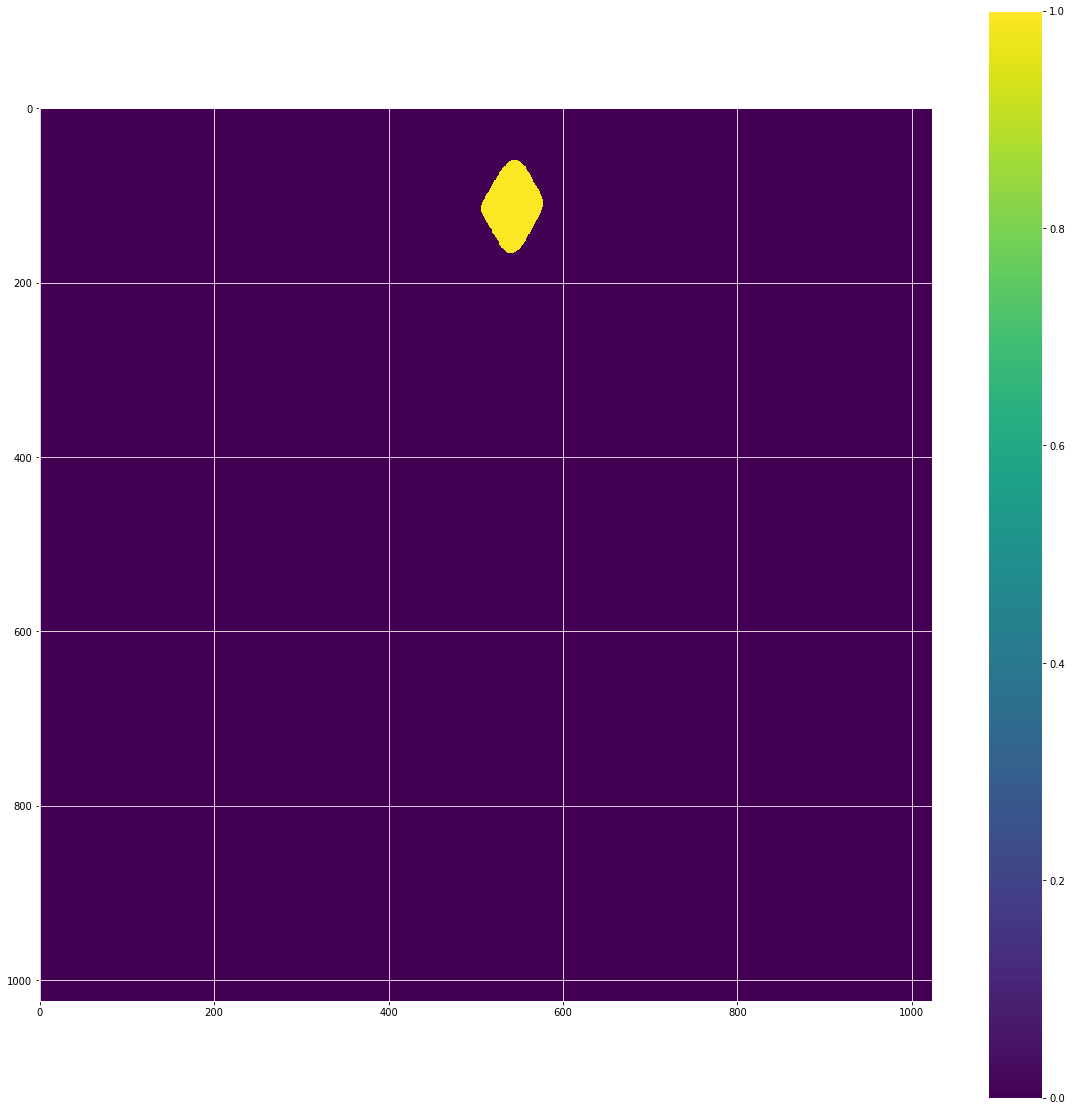

In [18]:
plt.imshow((labels==12)*1)
plt.colorbar()

In [19]:
N =[]
for i in range(50):
    img_ = corr.dat_to_numpy(list_files[199-i])
    img_ = vel.gaussian_filter(img_,4)
    img_ = (img_>0.5)*1
    labels = hosh.hoshenKoplemanLabels(img_)
    B = []
    for j in range(12,13):
        labelNumberForThisImage = labels[A[j][0]][A[j][1]]
        numberOfPixels = np.sum((labels==labelNumberForThisImage)*1)
        B.append(numberOfPixels)
    N.append(B)
    print(i)
 

0
1
2
3
4


KeyboardInterrupt: 

Text(0.5, 0, 'timestep x 500')

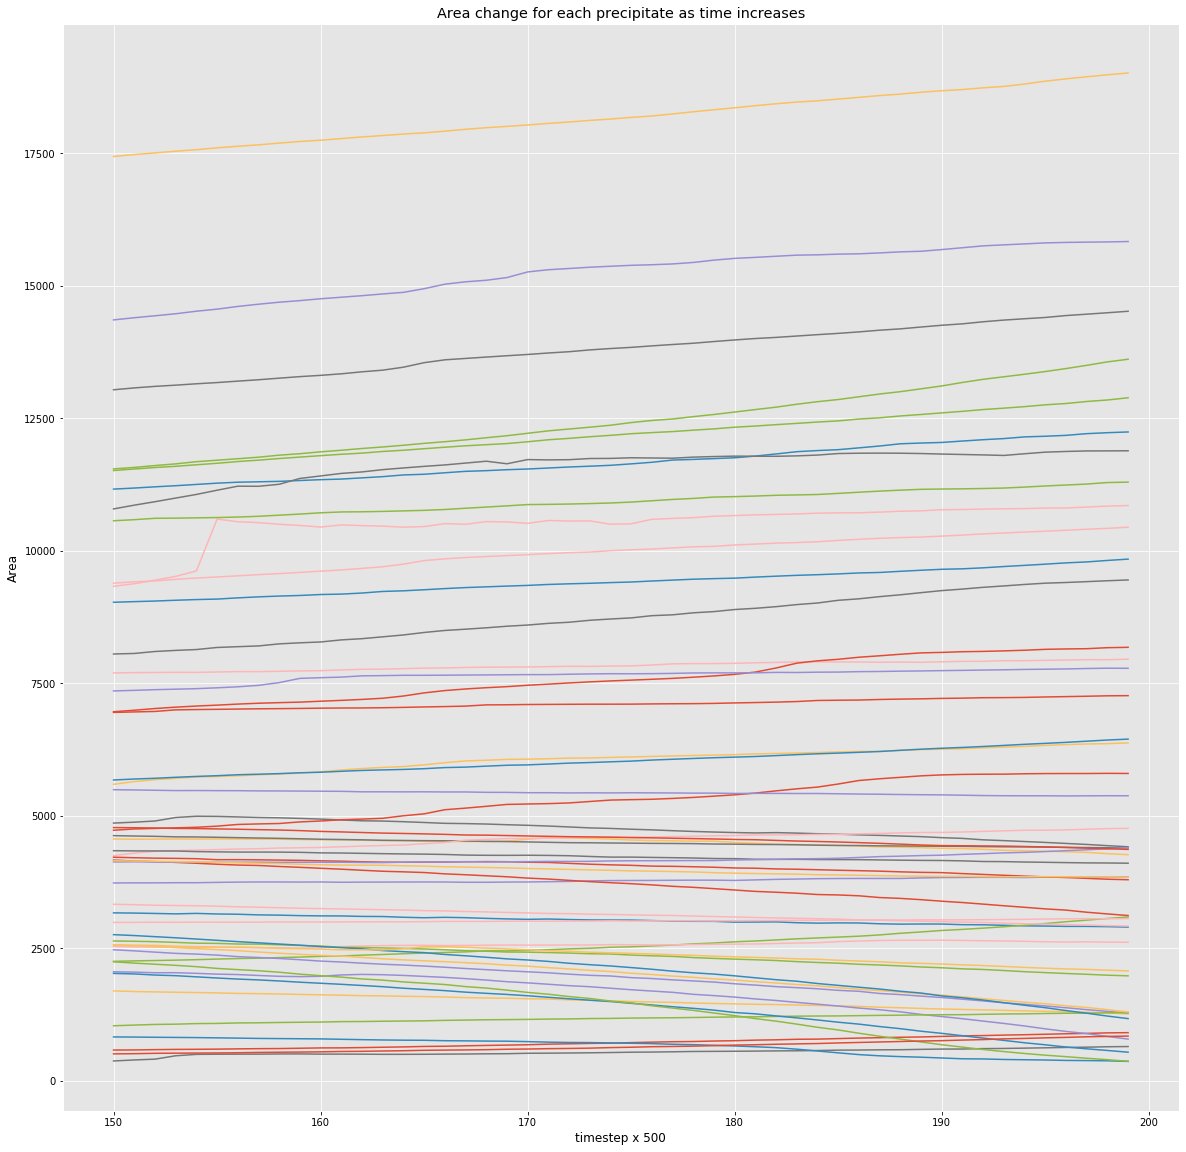

In [10]:
plt.rcParams["figure.figsize"] = (20,20)
Z = []
for i in range(50):
    Z.append(i+150)
    
for ii in range(50):
    graph = []
    for jj in range(50):
        graph.append(N[jj][ii])
    graph.reverse()
    plt.plot(Z,graph)
plt.title('Area change for each precipitate as time increases')
plt.ylabel('Area')
plt.xlabel('timestep x 500')
    
    

In [11]:
N[19][4]

1448

Text(0.5, 0, 'timestep x 500')

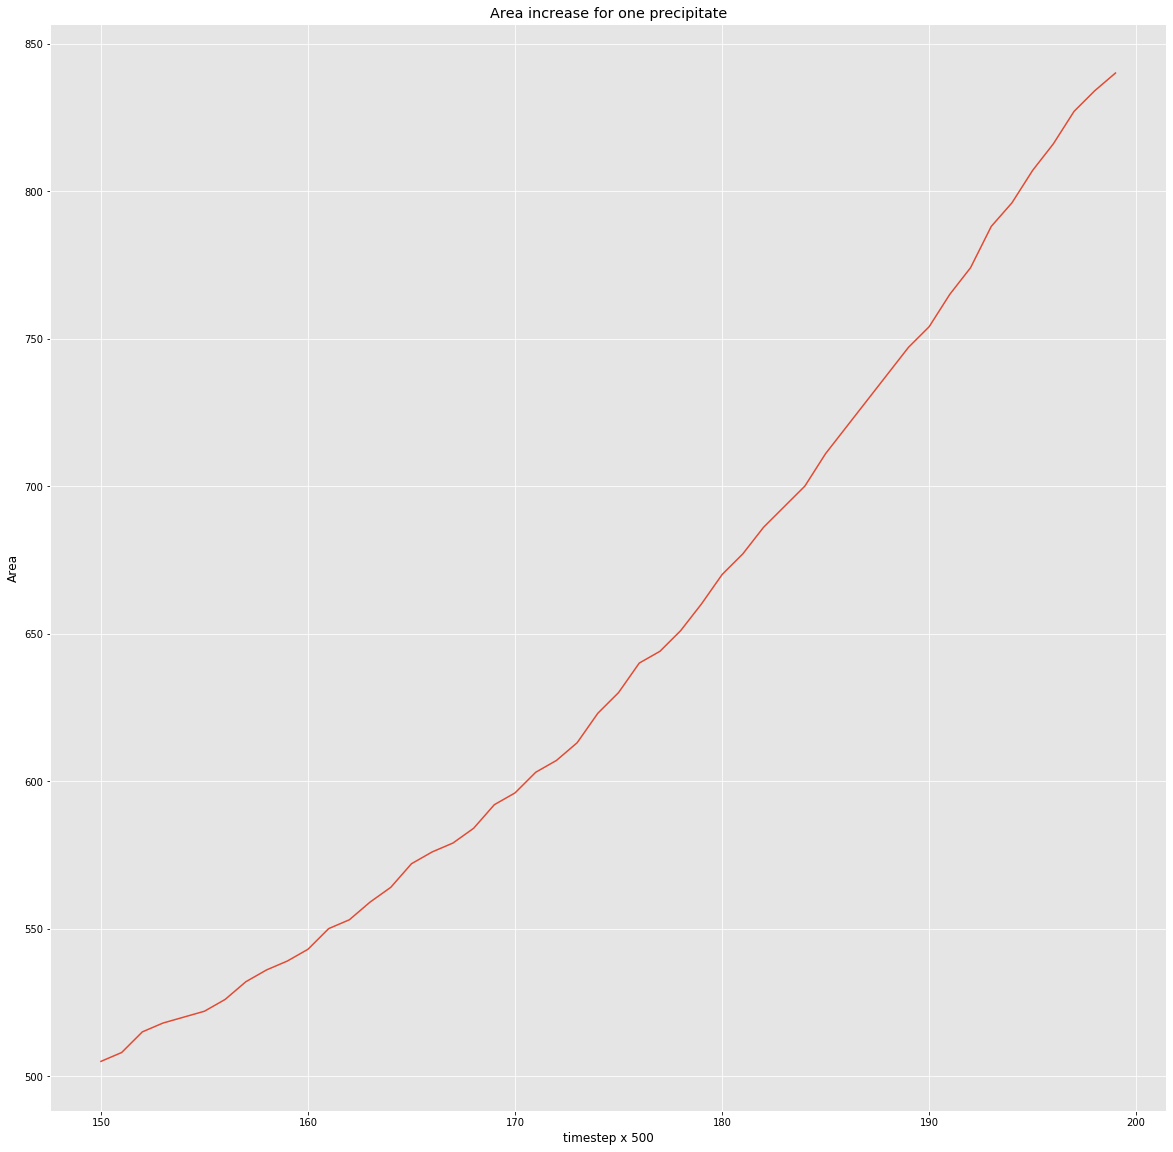

In [12]:
plt.plot(Z,graph)
plt.title('Area increase for one precipitate')
plt.ylabel('Area')
plt.xlabel('timestep x 500')

In [15]:
AreaChange = []
for i in range(1,len(graph)-1):
    AreaChange.append((graph[i+1]-graph[i-1])/2)

Text(0, 0.5, 'dA/dt')

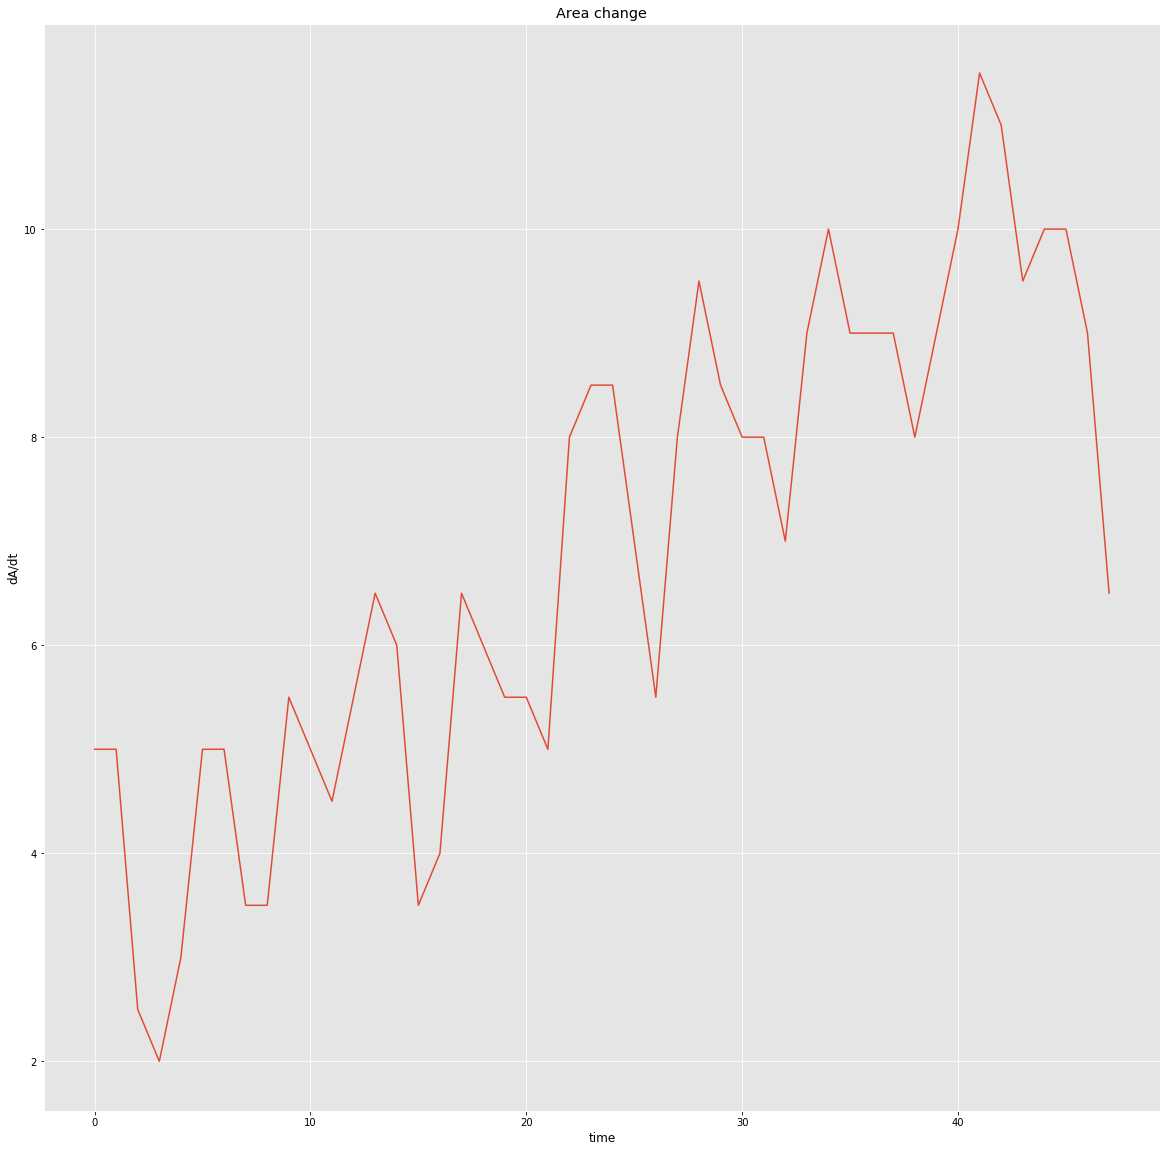

In [20]:
plt.plot(AreaChange)
plt.title('Area change')
plt.xlabel('time')
plt.ylabel('dA/dt')

Text(0.5, 0, 'Timestep of image')

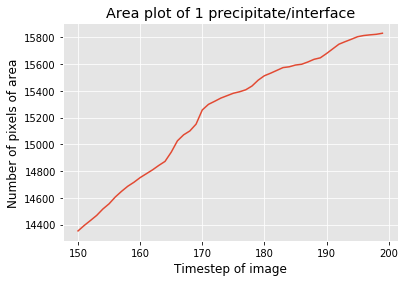

In [31]:
# C = []
# for i in range(50):
#     C.append(150+i)
# plt.plot(C,B)
# plt.title("Area plot of 1 precipitate/interface")
# plt.ylabel('Number of pixels of area')
# plt.xlabel('Timestep of image')

In [74]:
len(N)

50

[[1, 2, 3], [1, 2, 34, 5]]